In [1]:
import os 
os.environ['JAX_ENABLE_X64'] = 'True'
#numpyro.enable_x64()

import sys
sys.path.append(r'C:\Users\suhas\gsas2full\GSASII')

import jax
import numpy as np
from jax import core
import jax.numpy as jnp
from jax.interpreters import ad
from jax._src import abstract_arrays
from jax.experimental import host_callback as hcb
from numpyro.infer import Predictive
import arviz as az

import pandas as pd
import matplotlib.pyplot as plt
noise_scale=0.9

In [2]:



from b2.gsas import GSASModel           # I use a global env named b2, so i am importing gsas from b2
model_GSAS = GSASModel("TaTi-B2-new.gpx")

In [4]:
import os, sys
print(os.path.join(sys.base_prefix, r"C:\Users\suhas\gsas2full\GSASII\bindist"))

C:\Users\suhas\gsas2full\GSASII\bindist


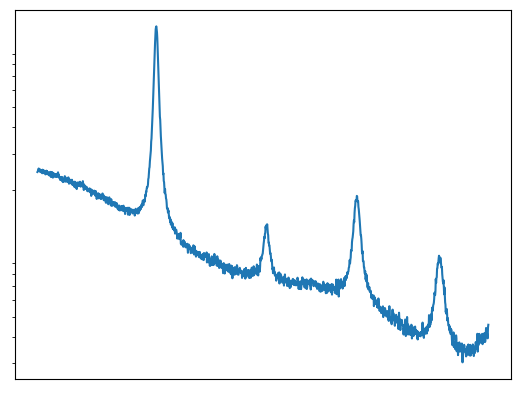

In [16]:
theta = np.round(np.linspace(20, 90, 1400), 3)
S = 0.22
RA = 0.5 * S + 0.5
occupancies = np.array([1-RA, 1-RA, RA, RA])
sz = 0.03
mustrain = 20000
simul = model_GSAS.forward(site_occupancies=occupancies, grainsize=sz, mustrain=mustrain)
simul_noise = np.random.normal(simul, noise_scale*np.sqrt(simul))
plt.title("S = {}, sz = {}, mustrain = {}".format(S, sz, mustrain))
plt.semilogy()
plt.xlabel("2theta")
plt.ylabel("Intensity")
plt.plot(theta, simul_noise)

In [2]:
def gsas_forward_host(site_occupancies, grainsize, mustrain): 
    return model_GSAS.forward(site_occupancies, grainsize, mustrain)

def gsas_forward(site_occupancies, grainsize, mustrain): 
    return jax.pure_callback(
        gsas_forward_host, 
        jax.ShapeDtypeStruct((1400,), dtype=jnp.float64), 
        site_occupancies, grainsize, mustrain)

gsas_forward = jax.custom_jvp(gsas_forward)

def gsas_derivative_host(site_occupancies, grainsize, mustrain):
    """Concrete implementation of the derivative primitive"""
    #global model_GSAS
    varnames = ["0::Afrac:0", "0::Afrac:1", "0::Afrac:2", "0::Afrac:3", "0:0:Size;i", "0:0:Mustrain;i"]
    all_dMdx, grad_data = model_GSAS.derivative(varnames)
    # build the jacobian matrix in order corresponding to `varnames`
    dMdx = pd.DataFrame(grad_data).values
    return dMdx

def gsas_derivative(site_occupancies, grainsize, mustrain):
    return jax.pure_callback(
        gsas_derivative_host, 
        jax.ShapeDtypeStruct((1400,6), dtype=jnp.float64), 
        site_occupancies, grainsize, mustrain)

@gsas_forward.defjvp
def gsas_forward_value_and_jvp(arg_values, arg_tangents):
    site_occupancies, grainsize, mustrain = arg_values
    site_occupancies_dot, grainsize_dot, mustrain_dot = arg_tangents
    primal_out = gsas_forward(site_occupancies, grainsize, mustrain)

    # evaluate gradiant at the input arg_values
    dMdx = gsas_derivative(site_occupancies, grainsize, mustrain)
    output_tangent = jnp.dot(dMdx, jnp.append(jnp.array(site_occupancies_dot), jnp.array([grainsize_dot, mustrain_dot])))
    return primal_out, output_tangent

In [3]:
import numpyro 
import numpyro.distributions as dist

read_pd_setting = pd.read_csv("TrialRangeData/setting.csv")              # setting df
read_pd_y_calc = pd.read_csv("TrialRangeData/diffraction_y_calc.csv")    # XRD
read_pd_yy = pd.read_csv("TrialRangeData/diffraction_yy.csv")        # noisy XRD
# ------------------------------------- convert to jnp -------------------------------------
setting_jnp = jnp.array(read_pd_setting[['order parameter', 'grain size', 'microstrain']])
y_calc_jnp = jnp.array(read_pd_y_calc)
yy_jnp = jnp.array(read_pd_yy)

def Inference_model(XRD_obs=y_calc_jnp[17]): # take 1 XRD pattern, y_calc_jnp[17] gives 1*1400 pts
    '''XRD_obs = the XRD pattern'''
    S = numpyro.sample('S', dist.Uniform(0, 1))
    RA = 0.5 * S + 0.5
    occupancies = jnp.array([1-RA, 1-RA, RA, RA])
    
    raw_sz = numpyro.sample('raw_sz', dist.LogNormal(0, 1))
    sz = numpyro.deterministic('sz', 5e-1*raw_sz)

    raw_microstrain = numpyro.sample('raw_microstrain', dist.LogNormal(0, 1))
    microstrain = numpyro.deterministic('microstrain', 5e4 * raw_microstrain)

    ycalc = numpyro.deterministic('ycalc', jnp.array(gsas_forward(occupancies, sz, microstrain)))
    numpyro.sample('yobs', dist.Normal(ycalc, noise_scale*jnp.sqrt(ycalc)), obs = XRD_obs)

/Users/ritalyu/opt/anaconda3/envs/G2/lib/python3.7/site-packages/arviz/stats/density_utils.py:606: UserWarning: Something failed: `x` does not contain any finite number.
  warnings.warn("Something failed: " + str(e))
/Users/ritalyu/opt/anaconda3/envs/G2/lib/python3.7/site-packages/arviz/stats/density_utils.py:606: UserWarning: Something failed: `x` does not contain any finite number.
  warnings.warn("Something failed: " + str(e))
/Users/ritalyu/opt/anaconda3/envs/G2/lib/python3.7/site-packages/arviz/stats/density_utils.py:606: UserWarning: Something failed: `x` does not contain any finite number.
  warnings.warn("Something failed: " + str(e))


array([[<AxesSubplot:title={'center':'S'}>,
        <AxesSubplot:title={'center':'S'}>],
       [<AxesSubplot:title={'center':'sz'}>,
        <AxesSubplot:title={'center':'sz'}>],
       [<AxesSubplot:title={'center':'microstrain'}>,
        <AxesSubplot:title={'center':'microstrain'}>]], dtype=object)

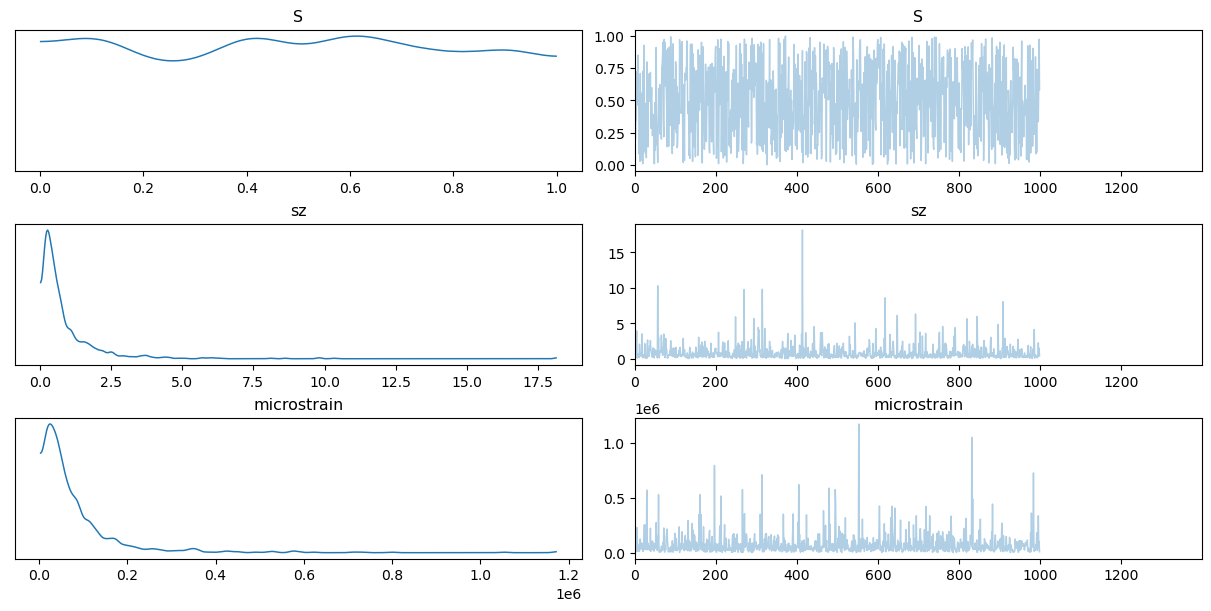

In [4]:
# prior check
from jax import random
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(Inference_model, num_samples=1000)
prior_prediction = prior_predictive(rng_key)
az.plot_trace(prior_prediction,var_names=['S','sz','microstrain'])
#os.getcwd()

## run inference

In [5]:
from numpyro.infer import MCMC, NUTS
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup = 500
num_samples = 1000

# run sampling 
kernel = NUTS(Inference_model, target_accept_prob=0.8)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1, chain_method = 'sequential')

mcmc.run(rng_key_, extra_fields=["num_steps"], XRD_obs=y_calc_jnp[108])
trace = az.convert_to_inference_data(mcmc)
trace.to_netcdf(f"InferenceResult/trace_{108}_{read_pd_setting['file name'][108]}.nc")  # remember to make a folder to save the result

In [9]:
# run inference on multiple XRD
pts_lst = [0,1,2,3] # XRD number
for i in pts_lst:
    kernel = NUTS(Inference_model, target_accept_prob=0.8)
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1, chain_method = 'sequential')

    xrd = y_calc_jnp[i]
    mcmc.run(rng_key_, extra_fields=["num_steps"], XRD_obs=xrd)
    trace = az.convert_to_inference_data(mcmc)
    trace.to_netcdf(f"InferenceResult/trace_{i}_{read_pd_setting['file name'][i]}.nc")

  0%|          | 0/1500 [00:00<?, ?it/s]/Users/ritalyu/opt/anaconda3/envs/G2/GSASII/GSASIIstrMath.py:2727: RuntimeWarning: invalid value encountered in double_scalars
  sig = (Sgam*(1.-parmDict[phfx+'Size;mx']))**2+(Mgam*(1.-parmDict[phfx+'Mustrain;mx']))**2
warmup:   0%|          | 1/1500 [00:02<1:13:04,  2.92s/it, 1 steps of size 2.34e+00. acc. prob=0.00]/Users/ritalyu/opt/anaconda3/envs/G2/GSASII/GSASIIstrMath.py:2742: RuntimeWarning: invalid value encountered in double_scalars
  sigDict[phfx+'Size;i'] = -3.6*Sgam*wave*(1.-parmDict[phfx+'Size;mx'])**2/(np.pi*costh*ateln2)
/Users/ritalyu/opt/anaconda3/envs/G2/GSASII/GSASIIstrMath.py:2768: RuntimeWarning: invalid value encountered in double_scalars
  sigDict[phfx+'Size;mx'] = -2.*Sgam**2*(1.-parmDict[phfx+'Size;mx'])/ateln2
/Users/ritalyu/opt/anaconda3/envs/G2/GSASII/GSASIIstrMath.py:2774: RuntimeWarning: invalid value encountered in double_scalars
  sigDict[phfx+'Mustrain;i'] =  0.036*Mgam*tanth*(1.-parmDict[phfx+'Mustrain;mx'])**2/(

## plot posterior trace

array([[<AxesSubplot:title={'center':'S'}>,
        <AxesSubplot:title={'center':'S'}>],
       [<AxesSubplot:title={'center':'sz'}>,
        <AxesSubplot:title={'center':'sz'}>],
       [<AxesSubplot:title={'center':'microstrain'}>,
        <AxesSubplot:title={'center':'microstrain'}>]], dtype=object)

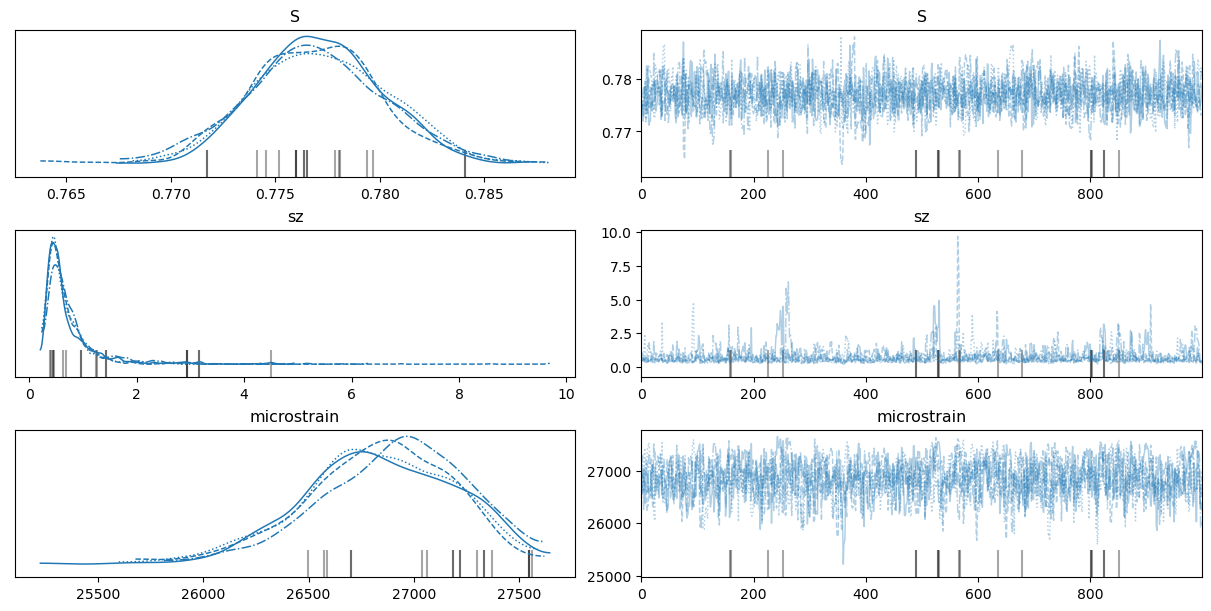

In [11]:
az.plot_trace(trace,var_names=['S', 'sz', 'microstrain'])

## read the trace from folder and plot posterior 

array([<AxesSubplot:title={'center':'S'}>,
       <AxesSubplot:title={'center':'sz'}>,
       <AxesSubplot:title={'center':'microstrain'}>], dtype=object)

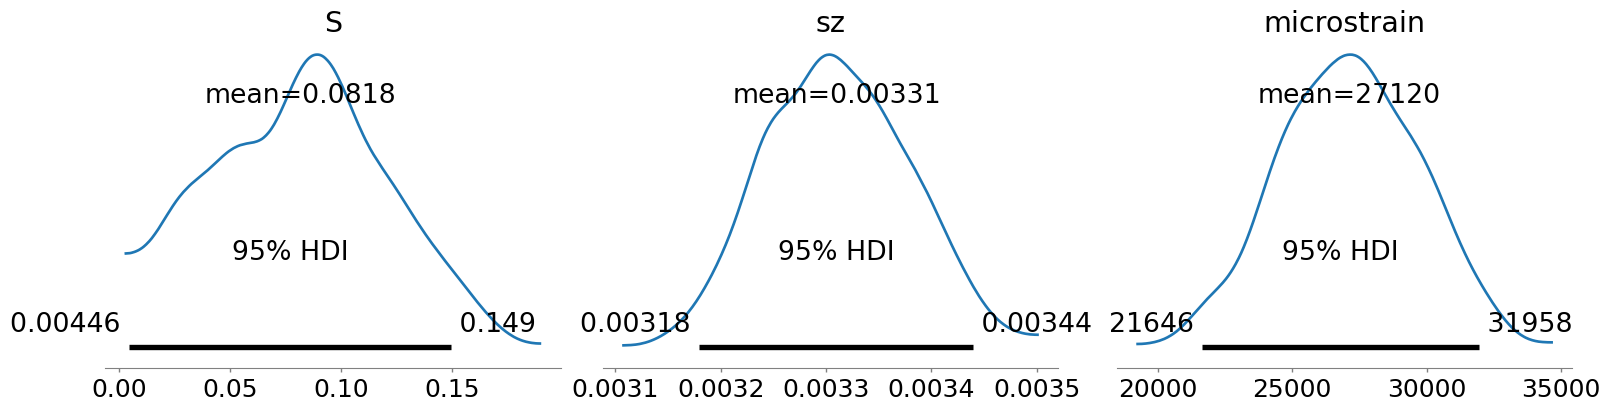

In [10]:
file = "trace_108_synthetic_b2_S=0.111_sz=0.003_microstrain=26777.778.nc"
trace = az.from_netcdf('InferenceResult/'+file)
# plot hdi
az.plot_posterior(trace, var_names=['S', 'sz', 'microstrain'], hdi_prob=.95, round_to=3, textsize=18, figsize=(16, 4))
#az.plot_trace(trace,var_names=['S', 'sz', 'microstrain'])

### plot confidence interval, calculate uncertainty

Text(0.5, 0, '2$\\theta$')

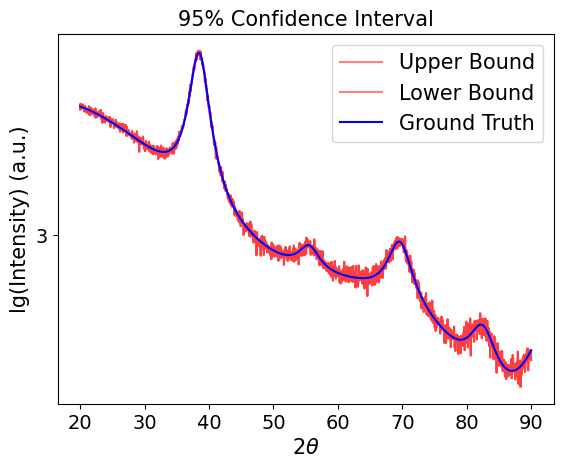

In [17]:
S_posterior = []
sz_posterior = []
microstrain_posterior = []
df_temp = trace.to_dataframe('posterior')
S_posterior.append(df_temp['S'])
sz_posterior.append(df_temp['sz'])
microstrain_posterior.append(df_temp['microstrain'])

# S_posterior = trace.posterior['S'].values
# sz_posterior = trace.posterior['sz'].values
# microstrain_posterior = trace.posterior['microstrain'].values

posterior_diffraction_y_calc = []
posterior_diffraction_yy = []

for i in range(len(S_posterior)): 
        S = S_posterior[0][i]
        RA = 0.5 * S + 0.5
        occupancies = [1-RA, 1-RA, RA, RA]
        y_calc = model_GSAS.forward(site_occupancies=occupancies, grainsize = sz_posterior[0][i], mustrain = microstrain_posterior[0][i])
        yy = np.random.normal(y_calc, np.sqrt(y_calc))

        posterior_diffraction_y_calc.append(y_calc)
        posterior_diffraction_yy.append(yy)

# posterior intensity for trace 3
theta = np.round(np.linspace(20, 90, 1400), 3)
posterior_df_diffraction_y_calc_trace3 = pd.DataFrame(posterior_diffraction_y_calc, columns = theta)
posterior_df_diffraction_yy_trace3 = pd.DataFrame(posterior_diffraction_yy, columns = theta)

# ------------------------------------- mean and confidence interval -------------------------------------
ci_mean = posterior_df_diffraction_yy_trace3.mean(axis = 0)
ci_lower = np.percentile(posterior_df_diffraction_yy_trace3, 2.5, axis = 0, interpolation = 'lower')
ci_upper = np.percentile(posterior_df_diffraction_yy_trace3, 97.5, axis = 0, interpolation = 'higher')
truth = read_pd_y_calc.iloc[108]

plt.ylabel("lg(Intensity) (a.u.)", fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.plot(theta, np.log10(ci_upper), 'r-', label = "Upper Bound", alpha = 0.5)
#plt.plot(theta, ci_mean, 'w', label = "Posterior Mean", alpha = 0.9)
plt.plot(theta, np.log10(ci_lower), 'r-', label = "Lower Bound", alpha = 0.5)
plt.plot(theta, np.log10(truth), 'b', label = "Ground Truth")         # ground truth
plt.yticks([3.0])
plt.title("95% Confidence Interval", fontsize = 15)
plt.legend(fontsize = 15)
plt.xlabel("2$\\theta$", fontsize=15)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [9]:
# get the posterior distribution of each parameter
posterior_S = trace.posterior.S.values
posterior_sz = trace.posterior.sz.values
posterior_microstrain = trace.posterior.microstrain.values

# get the mean of each parameter
mean_S = np.mean(posterior_S)
mean_sz = np.mean(posterior_sz)
mean_microstrain = np.mean(posterior_microstrain)

[]

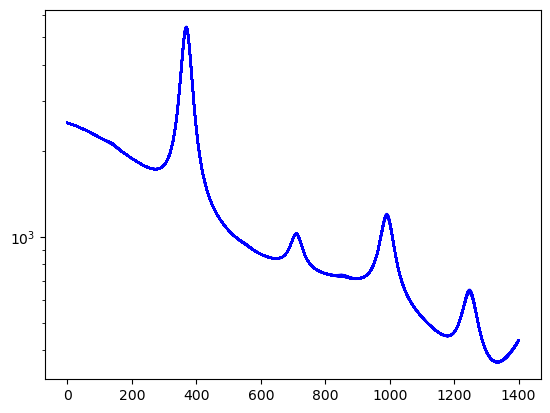

In [11]:
# posterior looks clean bc no noise 
for i in range(0, 1000): 
    S = posterior_S[0][i]
    RA = 0.5 * S + 0.5
    occupancies = np.array([1-RA, 1-RA, RA, RA])
    sz = posterior_sz[0][i]
    microstrain = posterior_microstrain[0][i]
    ycalc = np.array(model_GSAS.forward(occupancies, sz, microstrain))
    plt.plot(ycalc, color = 'blue', alpha=0.1)
    #plt.plot(ycalc, alpha=0.1, label = f"{i}")
    #plt.legend()
plt.semilogy()